In [50]:
import re
import numpy as np
import pandas as pd
import time
from random import random,randint
import matplotlib.pyplot as plt
import seaborn as sbn
import scipy.stats as st

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Amazon and Mercado Libre Data

In [3]:
data_meli = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_3.csv")
print(data_meli.shape)
for i in range(4,9):
  data_meli = pd.concat([data_meli, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_"+str(i)+".csv")])
  print(data_meli.shape)
data_meli.drop('Unnamed: 0', axis = 1, inplace = True)
data_meli.reset_index(drop = True, inplace = True)
data_meli["platform"] = "Mercado Libre"

(457, 23)
(929, 23)
(1404, 23)
(1877, 23)
(2347, 23)
(2817, 23)


In [4]:
data_meli.loc[0]

link             https://click1.mercadolibre.com.mx/mclics/clic...
title            Bocinas Bluetooth Portatil Altavoz Recargables...
n_reviews                                                       38
n_stars                                                        4.8
l_tree                                                           3
categories       ['Electrónica, Audio y Video', 'Audio', 'Bocin...
stock                                                           17
new                                                           True
sales_1                                              +100 vendidos
recommended                                                      0
free_delivery                                                 True
seller_name                                                    NaN
seller_link              https://perfil.mercadolibre.com.mx/EMUAEL
seller_sales                                                +10mil
ch_vec                                                        

In [5]:
data_amazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all.csv")
print(data_amazon.shape)
for i in range(2,7):
  data_amazon = pd.concat([data_amazon, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all_"+str(i)+".csv")]).reset_index(drop = True)
  print(data_amazon.shape)
data_amazon["platform"] = "Amazon"

(379, 11)
(760, 11)
(1137, 11)
(1513, 11)
(1889, 11)
(2264, 11)


In [6]:
data_amazon.loc[0]

page                                                             1
rank                                                             1
title                   JBL Flip 6 Bocina Portátil Bluetooth Negro
link             /JBL-Bocina-Port%C3%A1til-Bluetooth-Negro/dp/B...
n_stars                                                        4.8
n_reviews                                                   6408.0
curr_price                                                  1852.0
fast_delivery                                                 True
prime                                                         True
free_delivery                                                 True
date                                                      20230706
platform                                                    Amazon
Name: 0, dtype: object

In [7]:
data_amazon.date.unique()

array([20230706, 20230707, 20230708, 20230710, 20230711, 20230713])

## Data transformation

In [8]:
#Get dummies for benefits
meli_benefits = []
for ben_vec in data_meli.benefits:
  for benefit in re.sub("[\[\]'.]", "", ben_vec).split(","):
    meli_benefits.append(benefit.strip())
meli_benefits = list(set(meli_benefits))
data_meli["devolucion_gratis"] = data_meli["benefits"].apply(lambda x: meli_benefits[0] in x)
data_meli["mercado_puntos"] = data_meli["benefits"].apply(lambda x: meli_benefits[1] in x)
data_meli["compra_protegida"] = data_meli["benefits"].apply(lambda x: meli_benefits[2] in x)

In [9]:
#Get dummies for some characteristics

data_meli["bluetooth"] = data_meli["ch_vec"].apply(lambda x: "bluetooth" in x)
data_meli["usb_c"] = data_meli["ch_vec"].apply(lambda x: "USB-C" in x)
data_meli["bateria_recargable"] = data_meli["ch_vec"].apply(lambda x: "Batería recargable" in x)
data_meli["woofer"] = data_meli["ch_vec"].apply(lambda x: "woofer" in x)
data_meli["radio"] = data_meli["ch_vec"].apply(lambda x: "radio" in x)
data_meli["portatil"] = data_meli["ch_vec"].apply(lambda x: "portatil" in x)

In [10]:
#Power in watts
potencia = []
for ch in data_meli.ch_vec:
  if "Potencia de" in ch:
    potencia.append(float(ch[ch.find("Potencia de")+12:ch.find("W.")]))
  else:
    potencia.append(0)
data_meli["potencia_w"] = potencia

In [11]:
data_amazon["title"] = data_amazon["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))
data_meli["title"] = data_meli["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))

data_amazon["bluetooth"] = data_amazon["title"].apply(lambda x: ("bluetooth" in x))
data_amazon["bateria_recargable"] = data_amazon["title"].apply(lambda x: ("bateria" in x))
data_amazon["portatil"] = data_amazon["title"].apply(lambda x: ("portatil" in x))

In [12]:
data_meli["bluetooth"] = data_meli["title"].apply(lambda x: ("bluetooth" in x))
data_meli["bateria_recargable"] = data_meli["title"].apply(lambda x: ("bateria" in x))
data_meli["portatil"] = data_meli["title"].apply(lambda x: ("portatil" in x))

In [13]:
cols_in_common = ['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth','bateria_recargable', 'portatil', 'date']
data_all = pd.concat([data_meli[cols_in_common], data_amazon[cols_in_common]]).reset_index(drop = True)

In [14]:
brands = ["sony", "alexa", "amazon", "jbl", "bose", "yamaha", "lg", "echo", "kaiser", "logitech", "tlc", "sonos", "hisense", "samsung", "xiaomi"]
data_all["known_brand"] = data_all.title.apply(lambda x: any([br in x for br in brands]))

In [16]:
for var, obs in data_amazon.loc[2].items():
  print(var, " & ", obs, " \\\\")

page  &  1  \\
rank  &  3  \\
title  &  ultimate ears wonderboom 2 bocina inalambrica, bluetooth, sonido envolvente de 360°, resistente al agua ip67, conexion de 2 altavoces para sonido potente, bateria de 13 h - roja  \\
link  &  /Ultimate-Ears-Wonder-Boom-Rojo/dp/B07YYZW959/ref=sr_1_3?__mk_es_MX=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=21ZO1CHSPRT06&keywords=bocina&qid=1688679491&sprefix=bocina%2Caps%2C177&sr=8-3  \\
n_stars  &  4.9  \\
n_reviews  &  5322.0  \\
curr_price  &  1315.0  \\
fast_delivery  &  True  \\
prime  &  True  \\
free_delivery  &  True  \\
date  &  20230706  \\
platform  &  Amazon  \\
bluetooth  &  True  \\
bateria_recargable  &  True  \\
portatil  &  False  \\


In [ ]:
data_all.groupby(by = ["platform"]).describe().transpose()

In [ ]:
data_aux = data_all.groupby(by = ["title", "platform","date"]).count()
data_aux[data_aux.page >1].shape

(406, 11)

In [18]:
data_all = data_all.drop_duplicates(subset = ['title','platform','date'])

In [19]:
data_aux = data_all.groupby(by = ["title","platform"]).count()
data_aux[data_aux.page<4]

,,page,rank,link,n_stars,n_reviews,curr_price,free_delivery,bluetooth,bateria_recargable,portatil,date,known_brand
title,platform,,,,,,,,,,,,
bafle 15audiobahn procesamiento de señales digitales asd15,Mercado Libre,2,2,2,2,2,2,2,2,2,2,2,2
1 par de bocinas para portatiles 925306-001 izquierdo,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1
2 suspencion de caucho bocina audioban bazooka 12p+pegamento,Mercado Libre,2,2,2,2,2,2,2,2,2,2,2,2
"2x10 bocina doble 10 grande bluetooth con microfono, altavoces speaker inteligente para iphone,android y pc | luz led | sonido estereo | bateria recargable | bt/usb/tf/mc/fm/aux",Amazon,1,1,1,1,1,1,1,1,1,1,1,1
4 pz bocina para plafon 6 1/2 10w 8 ohms 065-828 t3324,Mercado Libre,3,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
yamaha bafle para media intemperie nsaw190 par blanco,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1
yamaha dxr12mkii bafle amplificado bocina 12 pulg 1100 watts,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1
yamaha ns-f350 negro par de bocinas para casa envio gratis,Mercado Libre,3,3,3,3,3,3,3,3,3,3,3,3


## Data cleaning

In [20]:
data_all = data_all[data_all.curr_price<data_all.curr_price.quantile(0.9)]

In [21]:
data_meli = data_meli[data_meli.curr_price<data_meli.curr_price.quantile(0.9)]

In [22]:
data_amazon = data_amazon[data_amazon.curr_price<data_amazon.curr_price.quantile(0.9)]

## Data Visualization

### Single variable exploration

In [23]:
sbn.set_palette("colorblind6")

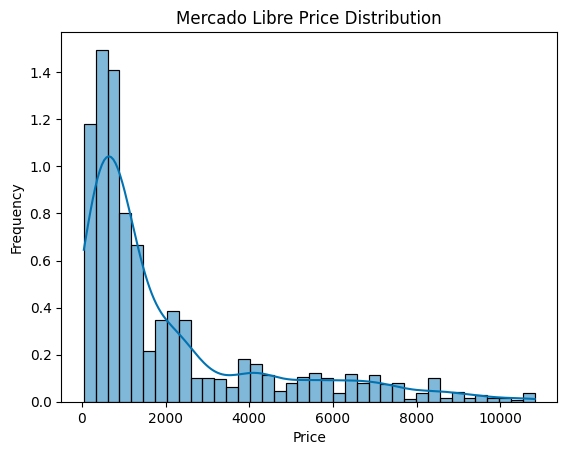

In [24]:
fig1 = sbn.histplot(data_meli, x = "curr_price", stat = "frequency", kde = True)
fig1.set(title='Mercado Libre Price Distribution', xlabel = "Price")
plt.show()

<Axes: title={'center': 'Mercado Libre Sales'}, xlabel='Sales', ylabel='count'>

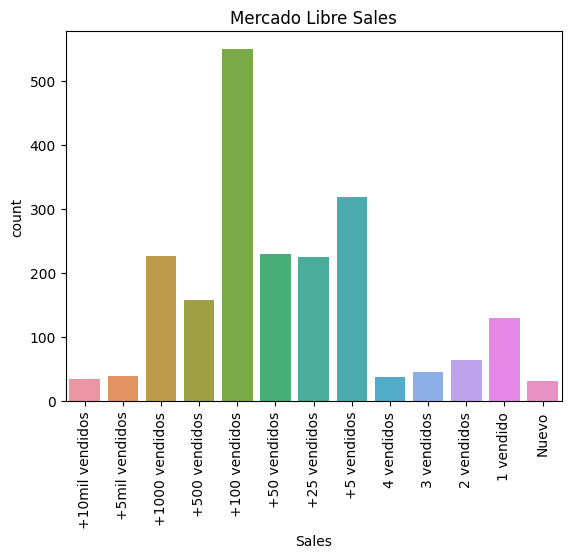

In [ ]:
fig2 = sbn.countplot(data_meli, x = "sales_1", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig2.set(title='Mercado Libre Sales', xlabel = "Sales")
fig2.tick_params(axis='x', rotation=90)
fig2

<Axes: title={'center': 'Mercado Libre Stock Distribution'}, xlabel='Stock', ylabel='Frequency'>

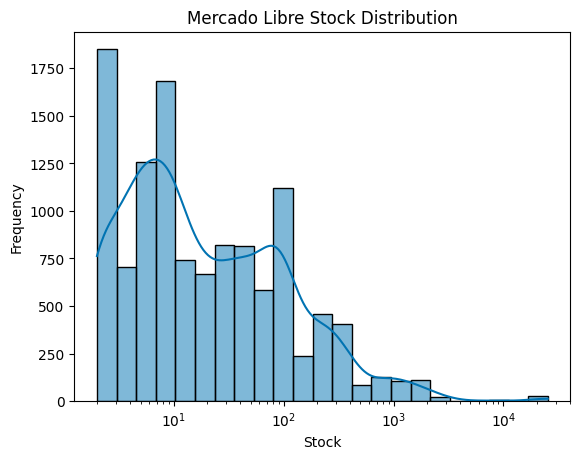

In [ ]:
fig3 = sbn.histplot(data_meli, x = "stock", stat = "frequency", kde = True, log_scale=True)
fig3.set(title='Mercado Libre Stock Distribution', xlabel = "Stock")
fig3

<Axes: title={'center': 'Mercado Libre Stock Distribution - Truncated'}, xlabel='Stock', ylabel='Frequency'>

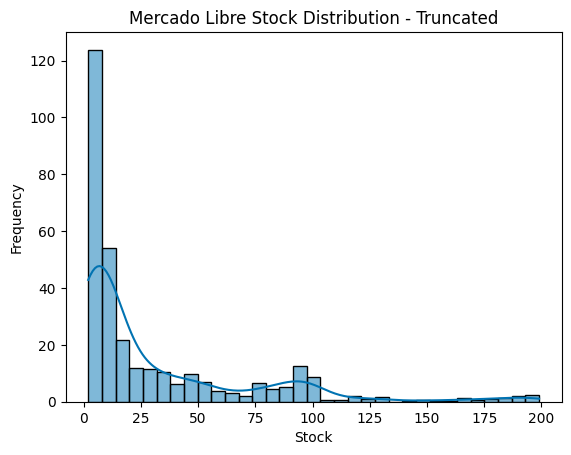

In [ ]:
fig4 = sbn.histplot(data_meli[data_meli.stock <200], x = "stock", stat = "frequency", kde = True)
fig4.set(title='Mercado Libre Stock Distribution - Truncated', xlabel = "Stock")
fig4

<Axes: title={'center': 'Consumption (W) distribution'}, xlabel='Consumption', ylabel='Frequency'>

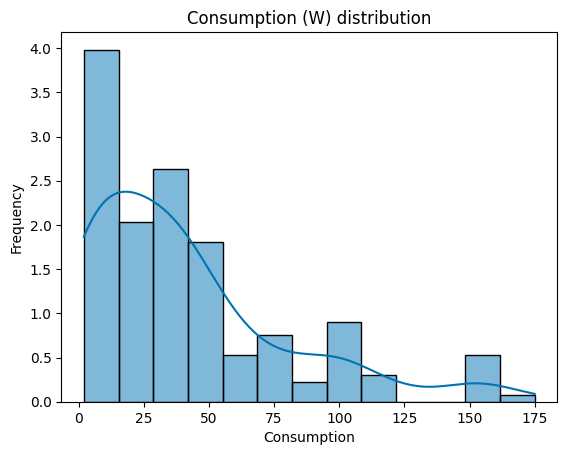

In [ ]:
fig5 = sbn.histplot(data_meli[(data_meli.potencia_w>0) & (data_meli.potencia_w<200) ], x = "potencia_w", stat = "frequency", kde = True)
fig5.set(title='Consumption (W) distribution', xlabel = "Consumption")
fig5

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

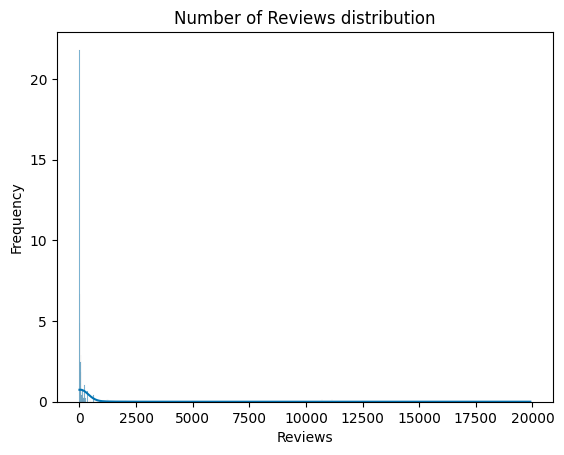

In [ ]:
fig6 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", kde = True)
fig6.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig6

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

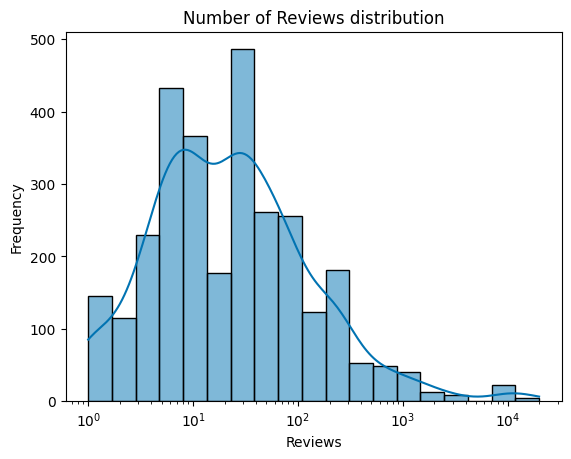

In [ ]:
fig7 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", log_scale = True, kde = True)
fig7.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig7

<Axes: title={'center': 'Mercado Libre Product Rating'}, xlabel='Rating', ylabel='Frequency'>

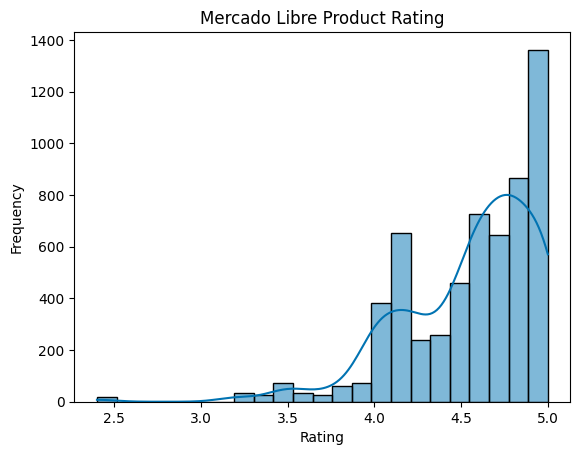

In [ ]:
fig8 = sbn.histplot(data_meli[data_meli.n_stars>0], x = "n_stars", stat = "frequency", kde = True)
fig8.set(title='Mercado Libre Product Rating', xlabel = "Rating")
fig8

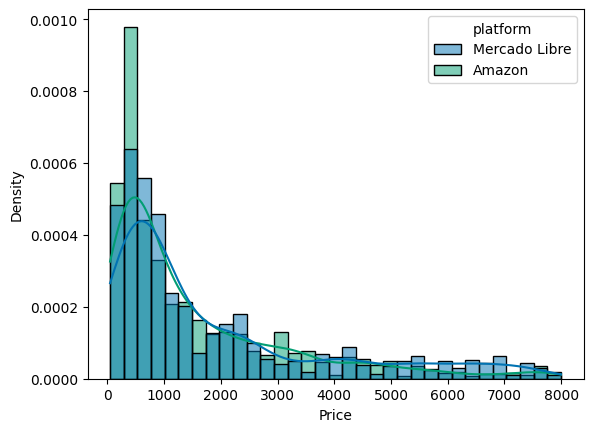

In [25]:
fig_all1 = sbn.histplot(data_all, x = "curr_price", stat = "density", hue= "platform", kde = True, common_norm = False)
fig_all1.set(xlabel = "Price")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/price_dist.png')
plt.show()

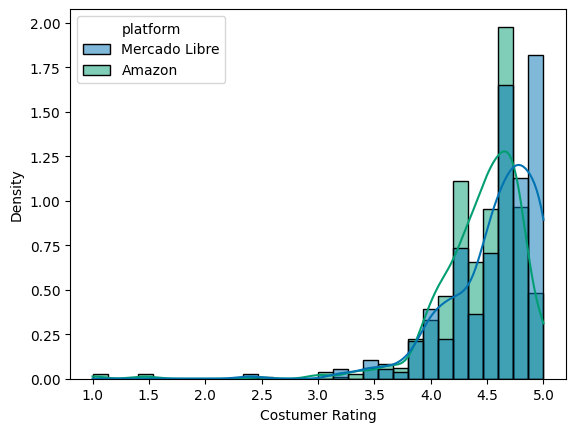

In [31]:
fig_all2 = sbn.histplot(data_all[data_all.n_reviews > 0], x = "n_stars", stat = "density", hue= "platform", kde = True, common_norm = False, bins = 30)
fig_all2.set( xlabel = "Costumer Rating")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rating_dist.png')
plt.show()

<Axes: title={'center': 'Review Count Distribution'}, xlabel='Review Count', ylabel='Frequency'>

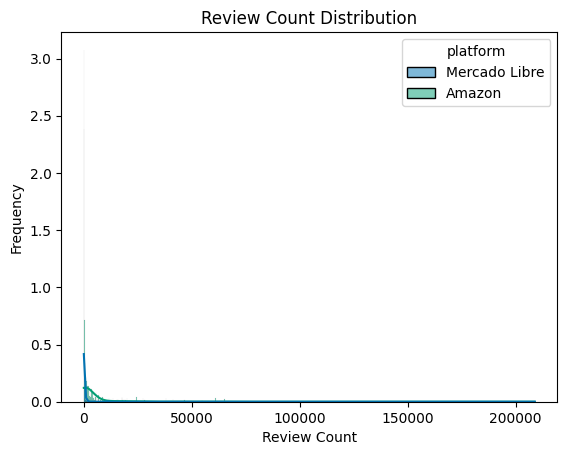

In [ ]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False)
fig_all3.set(title='Review Count Distribution', xlabel = "Review Count")
fig_all3

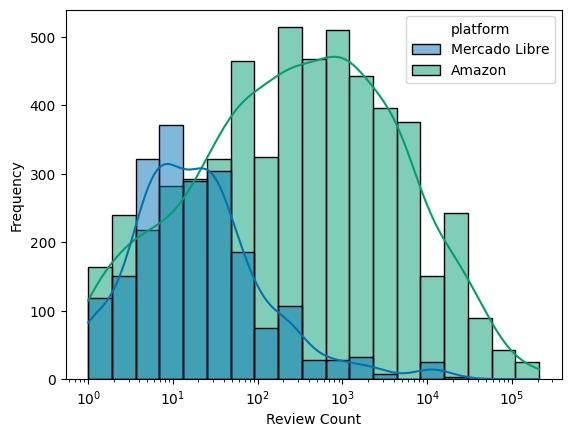

In [32]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False, log_scale = True)
fig_all3.set( xlabel = "Review Count")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rev_count_dist.png')
plt.show()


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


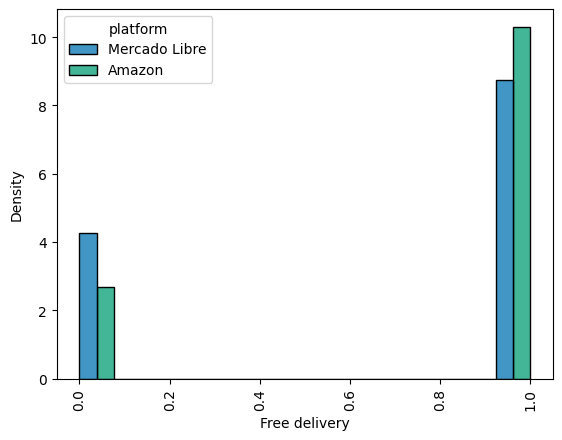

In [41]:
fig_all4 = sbn.histplot(data_all, x = "free_delivery", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all4.set(xlabel = "Free delivery")
fig_all4.tick_params(axis='x', rotation=90)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_dist.png')
plt.show()

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


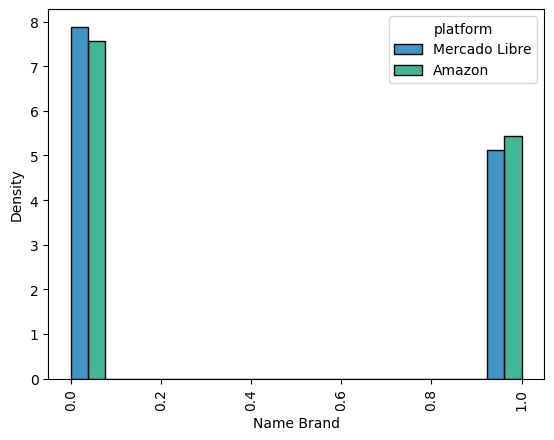

In [34]:
fig_all5 = sbn.histplot(data_all, x = "known_brand", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all5.set(xlabel = "Name Brand")
fig_all5.tick_params(axis='x', rotation=90)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_dist.png')
plt.show()

### Interaction Visualization

<Axes: title={'center': 'Mercado Libre Sales vs Price'}, xlabel='Sales', ylabel='Price'>

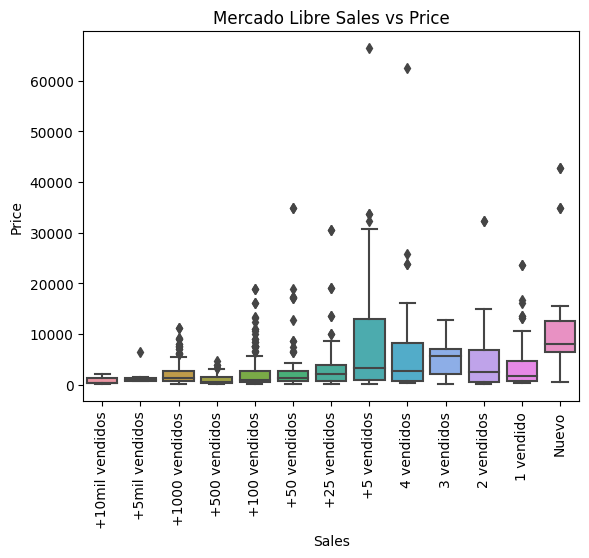

In [ ]:
fig9 = sbn.boxplot(data_meli, x = "sales_1", y = "curr_price", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig9.set(title='Mercado Libre Sales vs Price', xlabel = "Sales", ylabel = "Price")
fig9.tick_params(axis='x', rotation=90)
fig9

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

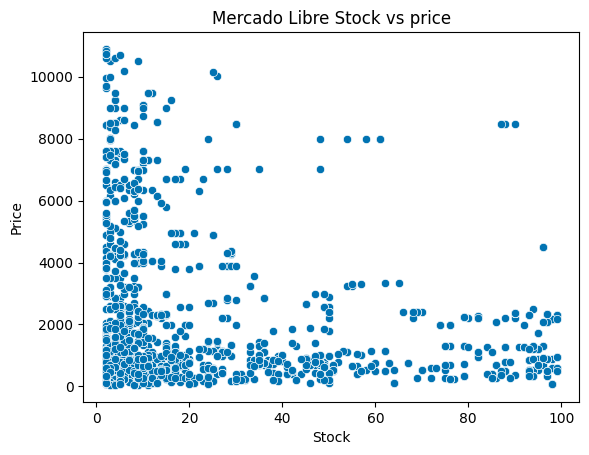

In [ ]:
fig10 = sbn.scatterplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price")
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

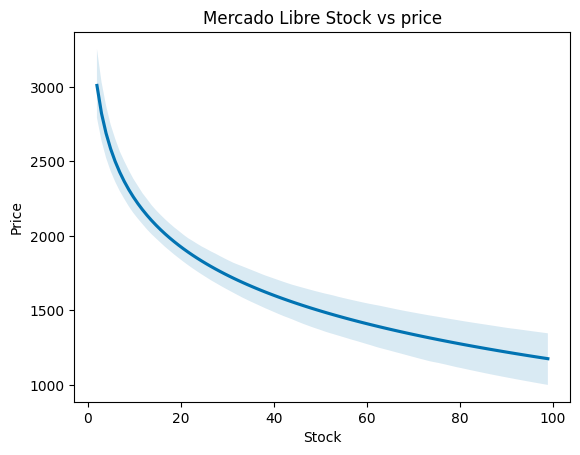

In [ ]:
fig10 = sbn.regplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price", logx = True, scatter = False)
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre New vs Used Prices'}, xlabel='New', ylabel='Price'>

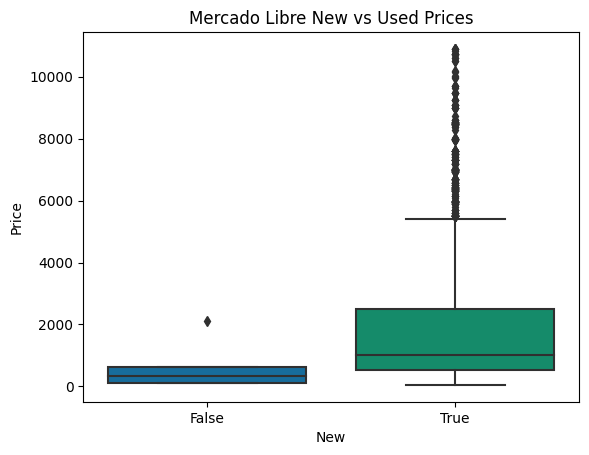

In [ ]:
fig11 = sbn.boxplot(data_meli, x = "new", y = "curr_price")
fig11.set(title='Mercado Libre New vs Used Prices', xlabel = "New", ylabel = "Price")
fig11

<Axes: title={'center': 'Mercado Libre Recomended Product Prices'}, xlabel='Recommended', ylabel='Price'>

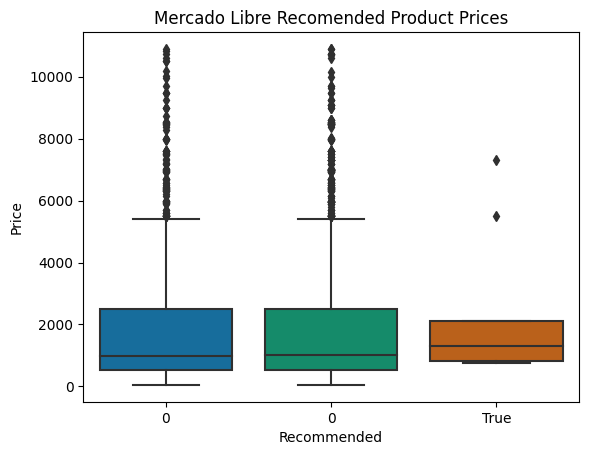

In [ ]:
fig12 = sbn.boxplot(data_meli, x = "recommended", y = "curr_price")
fig12.set(title='Mercado Libre Recomended Product Prices', xlabel = "Recommended", ylabel = "Price")
fig12

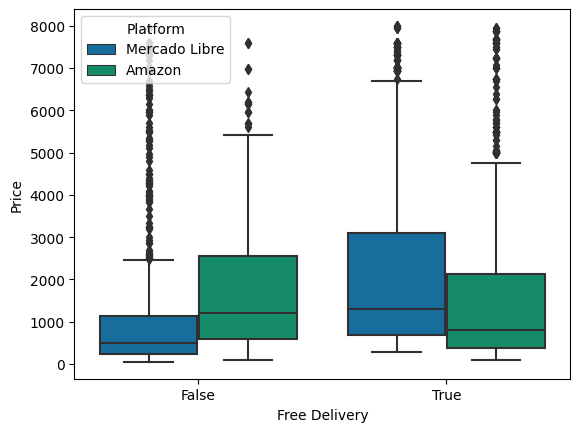

In [40]:
fig13 = sbn.boxplot(data_all, x = "free_delivery", y = "curr_price", hue = "platform")
fig13.set(xlabel = "Free Delivery", ylabel = "Price")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_prices_boxplot.png')
plt.show()

In [35]:
data_all.columns

Index(['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth', 'bateria_recargable',
       'portatil', 'date', 'known_brand'],
      dtype='object')

<Axes: title={'center': 'Mercado Libre Free vs Costly Returns Prices'}, xlabel='Free returns', ylabel='Price'>

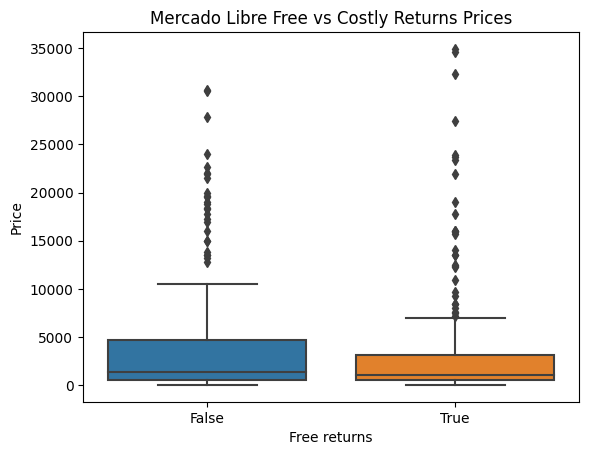

In [ ]:
fig14 = sbn.boxplot(data_meli, x = "devolucion_gratis", y = "curr_price")
fig14.set(title='Mercado Libre Free vs Costly Returns Prices', xlabel = "Free returns", ylabel = "Price")
fig14

<Axes: title={'center': 'Amazon Price Distribution'}, xlabel='Price', ylabel='Frequency'>

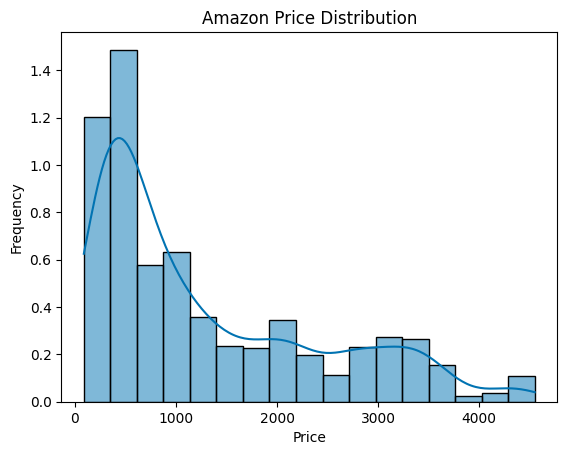

In [ ]:
fig2 = sbn.histplot(data_amazon, x = "curr_price", stat = "frequency", kde = True)
fig2.set(title='Amazon Price Distribution', xlabel = "Price")
fig2

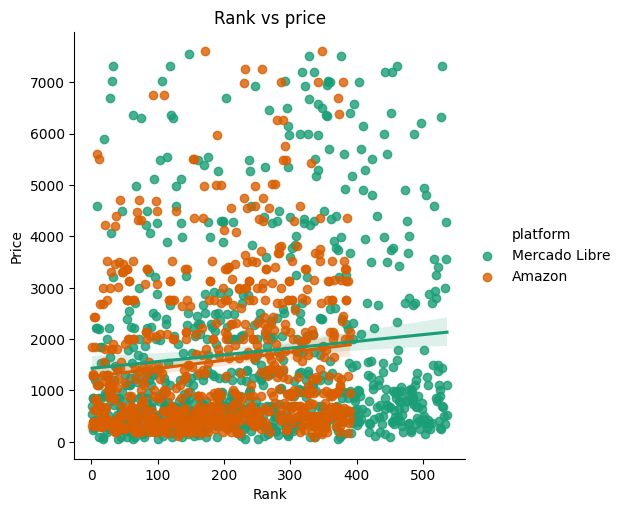

In [ ]:
fig_all5 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform")
fig_all5.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all5

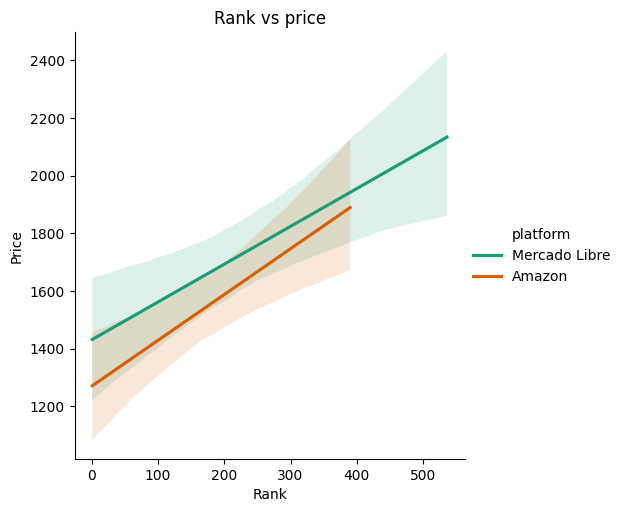

In [ ]:
fig_all6 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform", scatter = False)
fig_all6.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all6

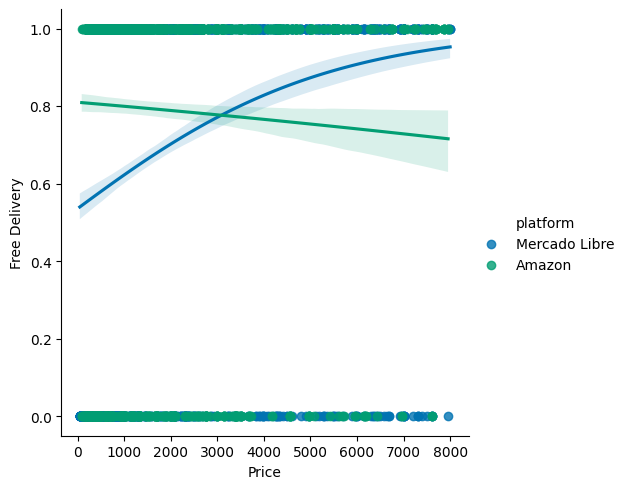

In [42]:
fig_all5 = sbn.lmplot(data_all, x = "curr_price", y = "free_delivery", hue = "platform", logistic = True)
fig_all5.set(xlabel = "Price", ylabel = "Free Delivery")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_price.png')
plt.show()

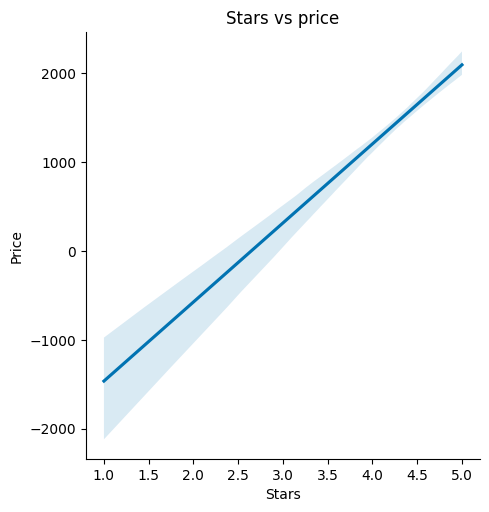

In [43]:
fig_all6 = sbn.lmplot(data_all[data_all.n_reviews > 0 ], x = "n_stars", y = "curr_price", scatter = False)
fig_all6.set(title='Stars vs price', xlabel = "Stars", ylabel = "Price")
plt.show()

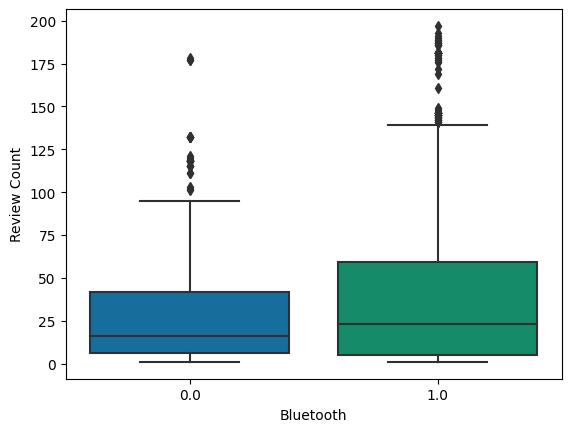

In [96]:
fig14 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "bluetooth", y = "n_reviews")
fig14.set(xlabel = "Bluetooth", ylabel = "Review Count")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/rev_boxplot.png')
plt.show()

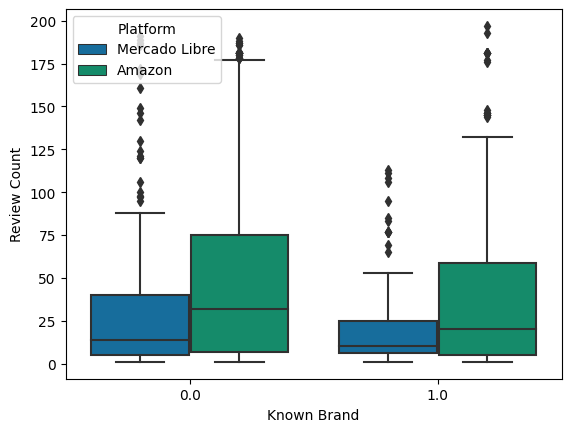

In [105]:
fig14 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "known_brand", y = "n_reviews", hue = "platform")
fig14.set(xlabel = "Known Brand", ylabel = "Review Count")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

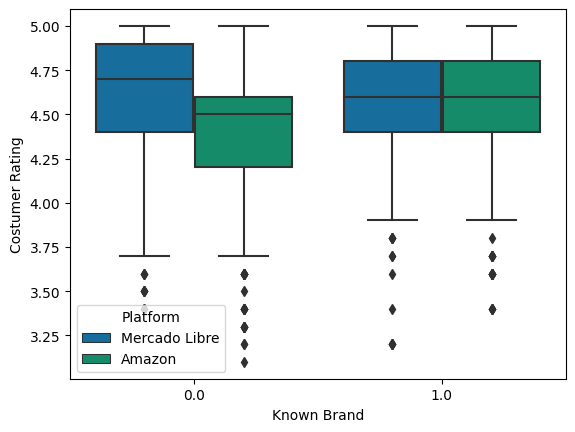

In [113]:
fig14 = sbn.boxplot(data_all[data_all.n_stars > 3], x = "known_brand", y = "n_stars", hue = "platform")
fig14.set(xlabel = "Known Brand", ylabel = "Costumer Rating")
plt.legend(loc='lower left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rat_boxplot.png')
plt.show()

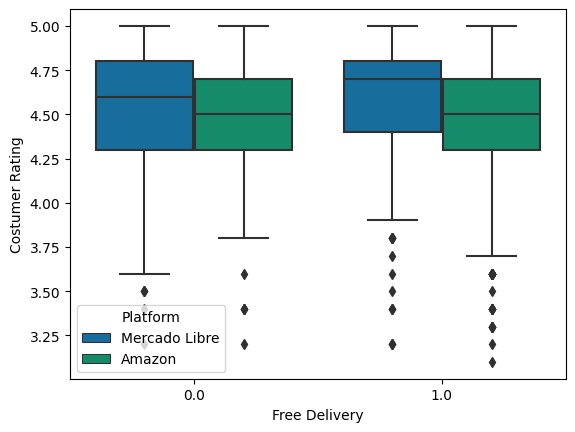

In [114]:
fig14 = sbn.boxplot(data_all[data_all.n_stars > 3], x = "free_delivery", y = "n_stars", hue = "platform")
fig14.set(xlabel = "Free Delivery", ylabel = "Costumer Rating")
plt.legend(loc='lower left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/free_del_rat_boxplot.png')
plt.show()

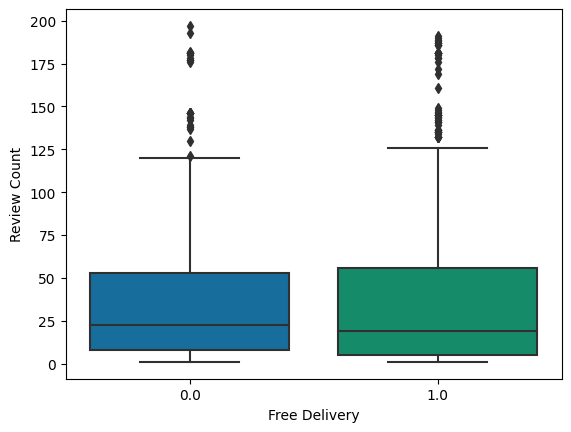

In [93]:
fig15 = sbn.boxplot(data_all[(data_all.n_reviews > 0 ) & (data_all.n_reviews < 200 )], x = "free_delivery", y = "n_reviews")
fig15.set(xlabel = "Free Delivery", ylabel = "Review Count")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

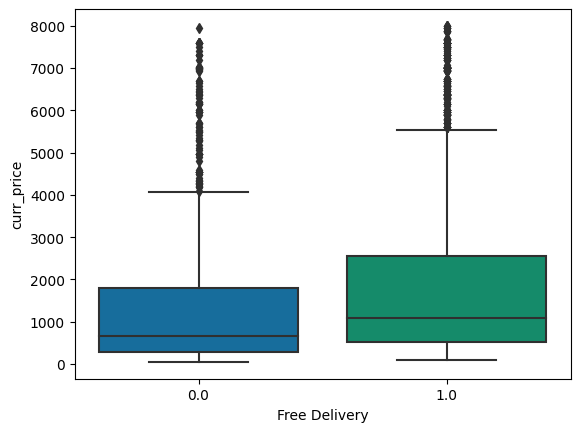

In [94]:
fig15 = sbn.boxplot(data_all, x = "free_delivery", y = "curr_price")
fig15.set(xlabel = "Free Delivery", ylabel = "curr_price")
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_rev_boxplot.png')
plt.show()

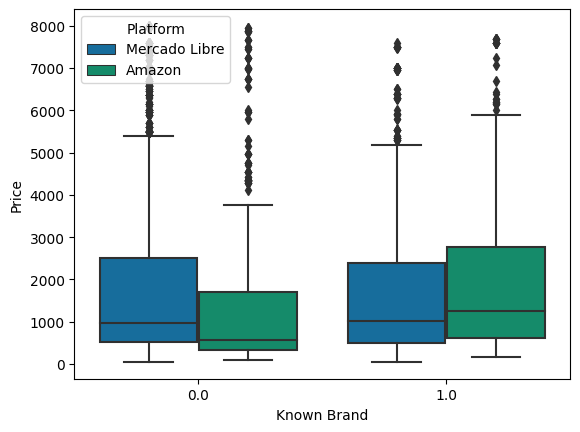

In [103]:
fig15 = sbn.boxplot(data_all, x = "known_brand", y = "curr_price", hue = "platform")
fig15.set(xlabel = "Known Brand", ylabel = "Price")
plt.legend(loc='upper left', title='Platform')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Figures/brand_price_boxplot.png')
plt.show()

In [45]:
data_all.bluetooth = data_all.bluetooth.astype(float)
data_all.known_brand = data_all.known_brand.astype(float)
data_all.free_delivery = data_all.free_delivery.astype(float)

In [57]:
data_meli.bluetooth = data_meli.bluetooth.astype(float)
data_meli.free_delivery = data_meli.free_delivery.astype(float)

In [58]:
data_amazon.bluetooth = data_amazon.bluetooth.astype(float)
data_amazon.free_delivery = data_amazon.free_delivery.astype(float)

In [ ]:
cols = ['n_stars', 'n_reviews', 'curr_price',
          'free_delivery', 'platform', 'bluetooth', 'known_brand']
for col in cols:
  if col != 'platform':
    print(col, data_all[cols].groupby(by = "platform").describe()[col])

In [60]:
data_aux_meli = data_meli[data_meli.n_reviews > 0]
data_aux_amazon = data_amazon[data_amazon.n_reviews > 0]
print(st.ttest_ind(data_aux_meli.n_stars,data_aux_amazon.n_stars, equal_var = False).pvalue)
print(st.ttest_ind(data_aux_meli.n_reviews,data_aux_amazon.n_reviews, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.curr_price,data_amazon.curr_price, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.free_delivery,data_amazon.free_delivery, equal_var = False).pvalue)
print(st.ttest_ind(data_meli.bluetooth,data_amazon.bluetooth, equal_var = False).pvalue)

8.47445752322142e-21
7.86861504211277e-31
7.462158588669845e-46
2.009537106889206e-06
2.4796804381931763e-38


In [63]:
print(st.ttest_ind(data_all[data_all.platform == "Mercado Libre"].known_brand,data_all[data_all.platform == "Amazon"].known_brand, equal_var = False).pvalue)

0.11963700759985653


In [70]:
data_meli["sales"] = data_meli.sales_1.str.replace("Nuevo", "0").str.replace("mil", "000").str.strip("+ vendidos").astype(float)
data_meli = data_meli[(data_meli.sales < data_meli.sales.quantile(0.9)) & (data_meli.n_reviews < data_meli.n_reviews.quantile(0.9)) ]

<Axes: xlabel='n_reviews', ylabel='sales'>

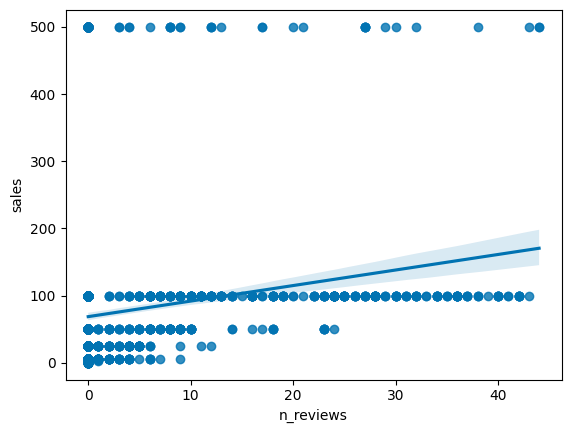

In [72]:
sbn.regplot(data_meli, x = 'n_reviews', y = 'sales' )

## Reduced Forms

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
y1 = np.array(data_meli.sales_1.str.replace("Nuevo", "0").str.replace("mil", "000").str.strip("+ vendidos").astype(float))

In [ ]:
data_meli.columns

Index(['link', 'title', 'n_reviews', 'n_stars', 'l_tree', 'categories',
       'stock', 'new', 'sales_1', 'recommended', 'free_delivery',
       'seller_name', 'seller_link', 'seller_sales', 'ch_vec', 'n_benefits',
       'benefits', 'curr_price', 'page', 'rank', 'title_initial', 'platform',
       'devolucion_gratis', 'mercado_puntos', 'compra_protegida', 'porencia_w',
       'potencia_w'],
      dtype='object')

In [ ]:
X = data_meli[["n_reviews", "n_stars", "stock", "new", "recommended", "free_delivery", "n_benefits", "curr_price", "page", "rank", "devolucion_gratis", "mercado_puntos", "compra_protegida", "potencia_w"]]
X["recommended"] = X["recommended"] == "True"
X = np.array(X.astype(float))
X = sm.add_constant(X)

<ipython-input-342-a5295bae45f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["recommended"] = X["recommended"] == "True"


In [ ]:
X = data_meli[["stock", "new", "free_delivery", "n_benefits", "curr_price", "page", "rank"]]
X = np.array(X.astype(float))
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y1, X)

In [ ]:
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.162
Date:                Tue, 04 Jul 2023   Prob (F-statistic):              0.323
Time:                        02:19:25   Log-Likelihood:                -3885.8
No. Observations:                 472   AIC:                             7788.
Df Residuals:                     464   BIC:                             7821.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6609    671.563      0.159      0.8